In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Preparing Required Frameworks

In [ ]:
# install dependencies: 
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

In [ ]:
!nvidia-smi

Fri Apr 29 03:41:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import pandas as pd
import cv2
import random
from google.colab.patches import cv2_imshow
import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

## Loading Data

In [ ]:
dir = '/content/gdrive/MyDrive/tooth numbering/new dataset/'
df = pd.read_csv(dir + 'new_data.csv')

data_list = df['file_name'].unique()
new_data_list = []
for file_name in data_list:
  name = file_name.split('.')[0]
  quadrant = name.split('_')[-1]
  if quadrant == 'ur' or quadrant == 'ul':
      new_data_list.append(file_name)

data_number = len(new_data_list)
data_idx = list(range(data_number))

random.shuffle(new_data_list)

split_idx = int(.85*data_number)
train_list, validation_list = new_data_list[:split_idx], new_data_list[split_idx:]

df_train = df[df['file_name'].isin(train_list)]
df_validation = df[df['file_name'].isin(validation_list)]

df_train.to_csv(dir + 'up/' + 'train.csv', index=False)
df_validation.to_csv(dir +'up/' + 'validation.csv', index=False)

print(data_number)
print(split_idx)
print(len(df_validation))
print(len(df_train))
df_train.head(30)

1988
1689
2119
12051


,file_name,width,height,x_min,x_max,y_min,y_max,class_name,image_source
0,U2_OPG_1_ur.jpg,914,487,6.0,226.0,19.0,290.0,18,SBMU University
1,U2_OPG_1_ur.jpg,914,487,112.0,293.0,111.0,450.0,17,SBMU University
2,U2_OPG_1_ur.jpg,914,487,266.0,442.0,130.0,471.0,16,SBMU University
3,U2_OPG_1_ur.jpg,914,487,411.0,530.0,174.0,470.0,15,SBMU University
4,U2_OPG_1_ur.jpg,914,487,507.0,640.0,149.0,479.0,14,SBMU University
5,U2_OPG_1_ur.jpg,914,487,589.0,721.0,93.0,470.0,13,SBMU University
6,U2_OPG_1_ur.jpg,914,487,706.0,798.0,166.0,464.0,12,SBMU University
7,U2_OPG_1_ur.jpg,914,487,792.0,905.0,180.0,471.0,11,SBMU University
8,U2_OPG_1_ul.jpg,936,450,818.0,924.0,107.0,437.0,21,SBMU University
9,U2_OPG_1_ul.jpg,936,450,722.0,814.0,132.0,427.0,22,SBMU University


## Creating Dataset

In [ ]:
def dataset_builder(dir, flag='None'):
  if flag=='train':
    # print('train data')
    path = os.path.join(dir+'up/', 'train.csv')
    df = pd.read_csv(path)
    df_filenames = df['file_name'].unique()
  elif flag=='validation':
    # print('validation data')
    path = os.path.join(dir+'up/', 'validation.csv')
    df = pd.read_csv(path)
    df_filenames = df['file_name'].unique()
  else:
    print('other data')

  datadict = []
  id = 1
  for filename in df_filenames:
    name = filename.split('.')[0]
    quadrant = name.split('_')[-1]
    if quadrant == 'ur':
      const = 11
    elif quadrant == 'ul':
      const = 21

    objs = []
    file_df = df[df['file_name'] == filename]
    for idx, row in file_df.iterrows():
      record = {}
      record['file_name'] = os.path.join(dir, 'crop_imgs', row['file_name'])
      record['image_id'] = id
      record['height'] = row['height']
      record['width'] = row['width']
      
      
      obj = {
            'bbox' : [row['x_min'], row['y_min'], row['x_max'], row['y_max']],
            'bbox_mode' : BoxMode.XYXY_ABS,
            'category_id' : row['class_name'] - const
        }
      objs.append(obj)

    record['annotations'] = objs
    datadict.append(record)
    id += 1
    
  return datadict

In [ ]:
dir = '/content/gdrive/MyDrive/tooth numbering/new dataset/'
data_dict = dataset_builder(dir, 'train')
print(len(data_dict))

1689


In [ ]:
dir = '/content/gdrive/MyDrive/tooth numbering/new dataset/'
for x in ['train', 'validation']:
  DatasetCatalog.register('numbering_' + x, lambda x=x : dataset_builder(dir, x))
  MetadataCatalog.get('numbering_' + x).set(thing_classes=['1', '2', '3', '4', '5', '6', '7', '8'])

In [ ]:
numbering_metadata = MetadataCatalog.get('numbering_train')
train_dataset = dataset_builder(dir, 'train')

## Visualizing some sample annotated data

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/drsh_2020_02_551_ul.jpg


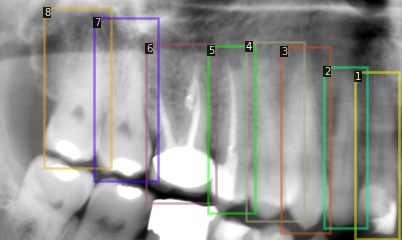

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/cate2-00113_ur.jpg


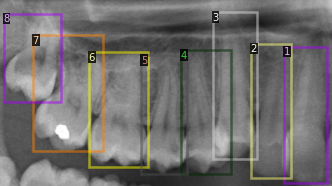

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/drsh_2020_02_103_ur.jpg


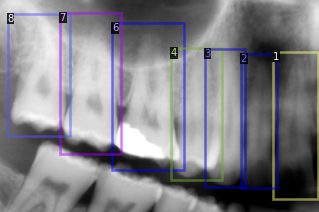

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/cate4-00081_ur.jpg


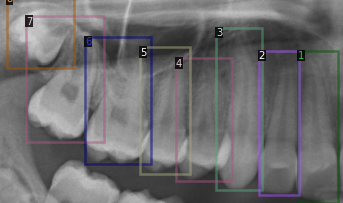

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/cate1-00044_ur.jpg


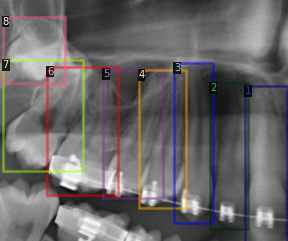

In [ ]:
for i in random.sample(train_dataset, 5):
  print(i['file_name'])
  img = cv2.imread(i['file_name'])
  visualizer = Visualizer(img[:, :, ::-1], metadata=numbering_metadata, scale=0.5)
  out = visualizer.draw_dataset_dict(i)
  cv2_imshow(out.get_image()[:, :, ::-1])

## Detectron2 Model Preparation

#### Defining a LossEvalHook in order to store train and validation loss:

In [ ]:
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime
import logging

class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()

        return losses
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
        
        
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)

#### Initializing model

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
class MyTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        os.makedirs("dental_eval", exist_ok=True)
        output_folder = "dental_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

  def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

In [ ]:
cfg = get_cfg()

# cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

# cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml'))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")

# cfg.merge_from_file(model_zoo.get_config_file('COCO-Detection/retinanet_R_50_FPN_3x.yaml'))
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_50_FPN_3x.yaml")

cfg.DATASETS.TRAIN = ('numbering_train',)
cfg.DATASETS.TEST = ("numbering_validation",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 400
cfg.SOLVER.MAX_ITER = 700
cfg.SOLVER.STEPS = (450,550,650)
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
# cfg.MODEL.RETINANET.NUM_CLASSES = 4
cfg.TEST.EVAL_PERIOD = 200

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg)
# trainer = DefaultTrainer(cfg) 

[04/29 03:41:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

## Training

In [ ]:
trainer.resume_or_load(resume=False)
trainer.train()

model_final_68d202.pkl: 663MB [00:15, 43.6MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[04/29 03:42:20 d2.engine.train_loop]: Starting training from iteration 0
[04/29 03:43:38 d2.utils.events]:  eta: 0:44:25  iter: 19  total_loss: 4.212  loss_cls: 2.031  loss_box_reg: 0.974  loss_rpn_cls: 1.010  loss_rpn_loc: 0.203  time: 3.9230  data_time: 0.0731  lr: 0.000048  max_mem: 5847M
[04/29 03:44:58 d2.utils.events]:  eta: 0:43:37  iter: 39  total_loss: 2.400  loss_cls: 1.153  loss_box_reg: 0.979  loss_rpn_cls: 0.071  loss_rpn_loc: 0.148  time: 3.9539  data_time: 0.0199  lr: 0.000098  max_mem: 5847M
[04/29 03:46:17 d2.utils.events]:  eta: 0:42:05  iter: 59  total_loss: 2.109  loss_cls: 0.950  loss_box_reg: 0.957  loss_rpn_cls: 0.060  loss_rpn_loc: 0.138  time: 3.9578  data_time: 0.0186  lr: 0.000148  max_mem: 5847M
[04/29 03:47:36 d2.utils.events]:  eta: 0:40:52  iter: 79  total_loss: 1.959  loss_cls: 0.848  loss_box_reg: 0.941  loss_rpn_cls: 0.037  loss_rpn_loc: 0.113  time: 3.9584  data_time: 0.0188  lr: 0.000198  max_mem: 5847M
[04/29 03:49:00 d2.utils.events]:  eta: 0:39:2

##Evaluating trained model

In [ ]:
!cp -v /content/output/* '/content/gdrive/MyDrive/tooth numbering/new dataset/up/result'

'/content/output/events.out.tfevents.1651203723.bf611809de40.74.0' -> '/content/gdrive/MyDrive/tooth numbering/new dataset/up/result/events.out.tfevents.1651203723.bf611809de40.74.0'
'/content/output/last_checkpoint' -> '/content/gdrive/MyDrive/tooth numbering/new dataset/up/result/last_checkpoint'
'/content/output/metrics.json' -> '/content/gdrive/MyDrive/tooth numbering/new dataset/up/result/metrics.json'
'/content/output/model_final.pth' -> '/content/gdrive/MyDrive/tooth numbering/new dataset/up/result/model_final.pth'


#### Ploting train and validation loss

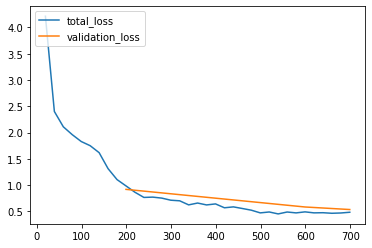

In [ ]:
import json
import matplotlib.pyplot as plt

experiment_folder = '/content/output'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

plt.plot(
    [x['iteration'] for x in experiment_metrics], 
    [x['total_loss'] for x in experiment_metrics])
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])
plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()

#### Evaluation on validation dataset

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("numbering_validation", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "numbering_validation")
inference_on_dataset(trainer.model, val_loader, evaluator)

[04/29 04:47:54 d2.data.common]: Serializing 299 elements to byte tensors and concatenating them all ...
[04/29 04:47:54 d2.data.common]: Serialized dataset takes 0.18 MiB
[04/29 04:47:54 d2.evaluation.evaluator]: Start inference on 299 images
[04/29 04:48:01 d2.evaluation.evaluator]: Inference done 11/299. 0.5947 s / img. ETA=0:02:52
[04/29 04:48:07 d2.evaluation.evaluator]: Inference done 20/299. 0.5989 s / img. ETA=0:02:48
[04/29 04:48:12 d2.evaluation.evaluator]: Inference done 29/299. 0.5873 s / img. ETA=0:02:39
[04/29 04:48:17 d2.evaluation.evaluator]: Inference done 38/299. 0.5823 s / img. ETA=0:02:32
[04/29 04:48:22 d2.evaluation.evaluator]: Inference done 47/299. 0.5768 s / img. ETA=0:02:26
[04/29 04:48:27 d2.evaluation.evaluator]: Inference done 56/299. 0.5735 s / img. ETA=0:02:20
[04/29 04:48:32 d2.evaluation.evaluator]: Inference done 65/299. 0.5745 s / img. ETA=0:02:15
[04/29 04:48:38 d2.evaluation.evaluator]: Inference done 74/299. 0.5752 s / img. ETA=0:02:10
[04/29 04:48

OrderedDict([('bbox',
              {'AP': 72.4860728495914,
               'AP-1': 74.37141320277391,
               'AP-2': 72.98508688018858,
               'AP-3': 72.18703879819012,
               'AP-4': 66.47395553795694,
               'AP-5': 70.78350683766368,
               'AP-6': 77.37615247042442,
               'AP-7': 75.0637218389208,
               'AP-8': 70.6477072306127,
               'AP50': 95.93929674994627,
               'AP75': 92.07965440723844,
               'APl': 72.48865242960579,
               'APm': nan,
               'APs': nan})])

#### Visualizing some outputs

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/drsh_2020_02_103_ul.jpg


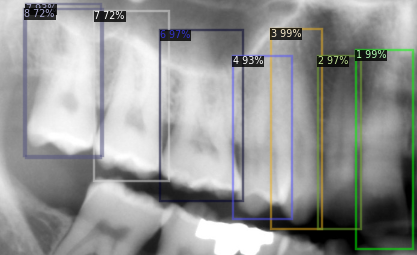

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/U2_OPG_140_ul.jpg


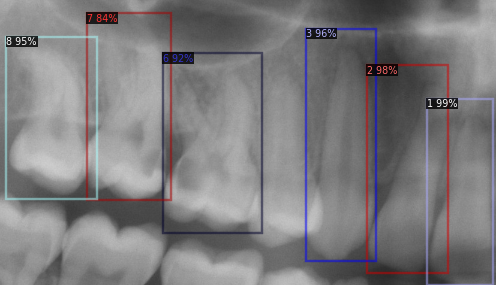

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/cate4-00096_ur.jpg


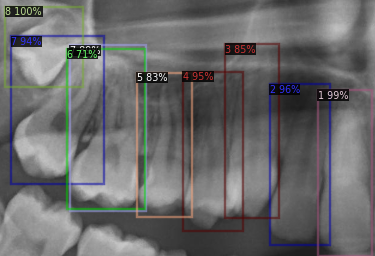

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/drsh_2020_02_177_ur.jpg


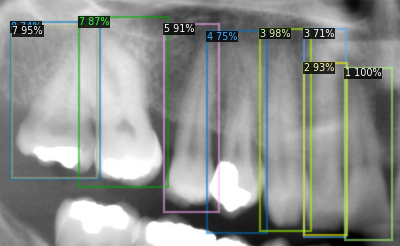

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/cate2-00078_ur.jpg


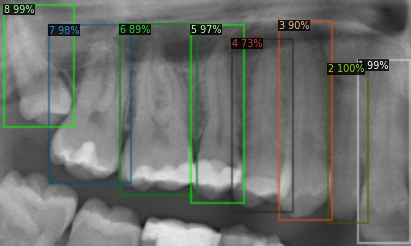

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/cate4-00006_ul.jpg


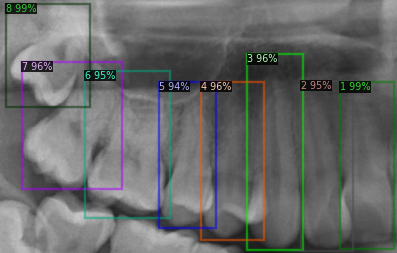

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/drsh_2021_04 (222)_ul.jpg


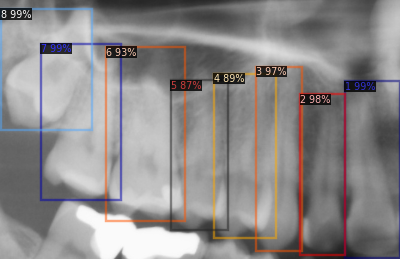

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/cate1-00034_ul.jpg


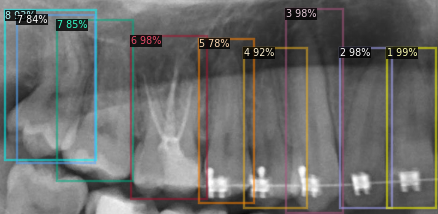

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/drsh_2020_02_560_ul.jpg


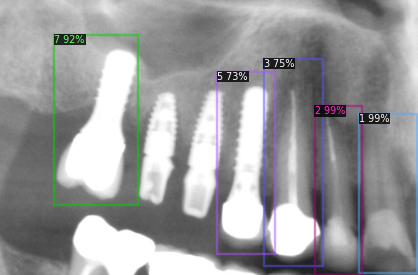

/content/gdrive/MyDrive/tooth numbering/new dataset/crop_imgs/drsh_2020_02_174_ur.jpg


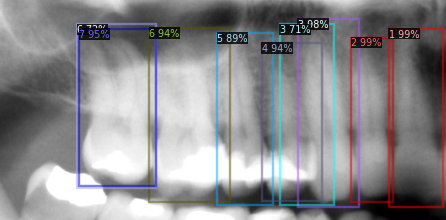

In [ ]:
dataset_dicts = dataset_builder(dir, 'validation')
for d in random.sample(dataset_dicts, 10):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=numbering_metadata, 
                   scale=0.6, 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(d["file_name"])
    cv2_imshow(out.get_image()[:, :, ::-1])